# **Implementação do SafeConnect** | `Plataforma Inteligente para Prevenção de Doenças em Redes Sociais.`

### 1. Importando as Bibliotecas Necessárias

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests
from io import StringIO

from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns

### 2. Carregando os Dados Reais

**Dados Utilizados:**

* Casos Confirmados de COVID-19: Número cumulativo de casos confirmados por país ao longo do tempo.

* Dados Demográficos: População por país.

**Fonte dos Dados:**

* Casos Confirmados: COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University.

* Dados Demográficos: World Bank Open Data.


Carregando os Dados de Casos Confirmados

In [ ]:
# URL do arquivo CSV com casos confirmados:
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data' \
                '/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

# Fazendo o download dos dados:
response = requests.get(url_confirmed)
confirmed_data = pd.read_csv(StringIO(response.text))

Visualizando os Dados

In [ ]:
print(confirmed_data.head())

  Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  2/28/23  3/1/23  3/2/23  3/3/23  \
0        0        0        0        0  ...   209322  209340  209358  209362   
1        0        0        0        0  ...   334391  334408  334408  334427   
2        0        0        0        0  ...   271441  271448  271463  271469   
3        0        0        0        0  ...    47866   47875   47875   47875   
4        0        0        0        0  ...   105255  105277  105277  105277   

   3/4/23  3/5/23  3/6/23  3/7/23  3/8/23  3/9/23  
0  209369  209390  209406  2

### 3. Processamento dos Dados

Agregando os Dados por País

In [ ]:
# Agrupando por país:
confirmed_data = confirmed_data.groupby('Country/Region').sum().reset_index()

# Removendo colunas desnecessárias:
confirmed_data = confirmed_data.drop(columns=['Lat', 'Long', 'Province/State'])

Calculando Novos Casos Diários

In [ ]:
# Transpondo os dados para que as datas sejam linhas
confirmed_data_melted = confirmed_data.melt(id_vars=['Country/Region'], var_name='Date', value_name='Confirmed')

# Convertendo a coluna 'Date' para datetime:
confirmed_data_melted['Date'] = pd.to_datetime(confirmed_data_melted['Date'])

# Ordenando os dados:
confirmed_data_melted = confirmed_data_melted.sort_values(['Country/Region', 'Date'])

# Calculando novos casos diários:
confirmed_data_melted['New_Cases'] = confirmed_data_melted.groupby('Country/Region')['Confirmed'].diff().fillna(0)

# Clipping dos valores negativos em 'New_Cases' para zero
confirmed_data_melted['New_Cases'] = confirmed_data_melted['New_Cases'].clip(lower=0)


<ipython-input-5-29d10da762d9>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  confirmed_data_melted['Date'] = pd.to_datetime(confirmed_data_melted['Date'])


Carregando Dado Demográficos

In [ ]:
# URL dos dados de população:
url_population = 'https://raw.githubusercontent.com/datasets/population/master/data/population.csv'

# Carregando os dados:
population_data = pd.read_csv(url_population)

# Filtrando para o ano mais recente disponível:
population_data = population_data[population_data['Year'] == population_data['Year'].max()]
population_data = population_data[['Country Name', 'Value']]
population_data.columns = ['Country/Region', 'Population']

Mesclando os Dados

In [ ]:
# Mesclando os dados de casos confirmados com os dados de população:
data = pd.merge(confirmed_data_melted, population_data, on='Country/Region', how='left')

Transformação das Variáveis e Engenharia de Características



1. Remoção de Dados Ausentes: Removemos países sem informação de população.

2. Engenharia de Características:

 * Criamos variáveis per capita para normalizar em relação ao tamanho da população.

3. Transformação Logarítmica:
 * Aplicamos `np.log1p` para lidar com zero e reduzir a assimetria

In [ ]:
# Removendo países com população ausente
data = data.dropna(subset=['Population'])

# Calculando casos confirmados per capita
data['Confirmed_per_Capita'] = data['Confirmed'] / data['Population']

# Calculando novos casos per capita
data['New_Cases_per_Capita'] = data['New_Cases'] / data['Population']

# Aplicando transformação logarítmica para reduzir assimetria
data['Log_Confirmed'] = np.log1p(data['Confirmed'])
data['Log_New_Cases'] = np.log1p(data['New_Cases'])
data['Log_Population'] = np.log1p(data['Population'])

<ipython-input-8-2143ac134215>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Confirmed_per_Capita'] = data['Confirmed'] / data['Population']
<ipython-input-8-2143ac134215>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['New_Cases_per_Capita'] = data['New_Cases'] / data['Population']
<ipython-input-8-2143ac134215>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

### 4. Análise de Network Science

Embora não tenhamos dados de rede social individual, podemos criar uma rede baseada nas interações entre países (por exemplo, proximidade geográfica, fluxo de viagens). Para simplificar, vamos criar uma rede baseada nos países e suas conexões.

Criando uma Rede Simplificada de Países

In [ ]:
# Para fins de exemplo, é criado uma rede simples onde todos os países estão conectados.
# Em uma aplicação real, poderia ser usado dados reais de conexões, como rotas de voo.

countries = data['Country/Region'].unique()
G = nx.Graph()

# Adicionando nós (países):
G.add_nodes_from(countries)

# Conectando todos os países (grafo completo) - simplificação:
for i in range(len(countries)):
    for j in range(i+1, len(countries)):
        G.add_edge(countries[i], countries[j])


Atribuindo Atributos aos Nós


In [ ]:
# Atribuindo atributos de população aos nós:
population_dict = population_data.set_index('Country/Region')['Population'].to_dict()
nx.set_node_attributes(G, population_dict, 'population')

### 5. Preparação dos Dados para Modelagem

Selecionando uma Data Específica

In [ ]:
# Selecionando dados de uma data específica:
selected_date = data['Date'].max()
data_date = data[data['Date'] == selected_date]

Criando o DataFrame para Modelagem e Tratando Valores Inválidos

In [ ]:
# Criando o DataFrame com as novas características:
df_model = data_date[['Country/Region', 'Log_New_Cases', 'Log_Confirmed', 'Log_Population',
                      'Confirmed_per_Capita', 'New_Cases_per_Capita']]

# Substituir inf/-inf por NaN e remover entradas inválidas:
df_model = df_model.replace([np.inf, -np.inf], np.nan)
df_model = df_model.dropna()

# Verificando o tamanho do conjunto de dados:
print("Número de amostras no conjunto de dados:", df_model.shape[0])

Número de amostras no conjunto de dados: 171


Variáveis Independentes e Dependente

In [ ]:
# Variáveis independentes:
X = df_model[['Log_Confirmed', 'Log_Population', 'Confirmed_per_Capita']]

# Variável dependente para regressão:
y_reg = df_model['Log_New_Cases']

# Variável dependente para classificação (alta ou baixa incidência de novos casos):
threshold = y_reg.median()
y_class = (y_reg >= threshold).astype(int)

# Contagem de classes:
class_counts = y_class.value_counts()
print("Contagem de classes:\n", class_counts)

Contagem de classes:
 Log_New_Cases
1    171
Name: count, dtype: int64


### 6. Divisão dos Dados em Treino e Teste

Escalonamento das Características

1. Aplicação do Escalonamento:
 * Usamos StandardScaler para normalizar as características.

In [ ]:
# Divisão dos dados:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
y_train_class, y_test_class = train_test_split(y_class, test_size=0.2, random_state=42)

# Escalonamento dos dados:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### 7. Regressão e Predição

Uso do Random Forest Regressor com Validação Cruzada

In [ ]:
# Modelo Random Forest Regressor com parâmetros ajustados para evitar overfitting:
rf_regressor = RandomForestRegressor(
    random_state=42,
    n_estimators=100,
    max_depth=5,               # **Alteração:** Limitar a profundidade máxima
    min_samples_split=10,      # **Alteração:** Número mínimo de amostras para dividir um nó
    min_samples_leaf=5         # **Alteração:** Número mínimo de amostras em uma folha
)
rf_regressor.fit(X_train_scaled, y_train_reg)

# Previsão:
y_pred_reg = rf_regressor.predict(X_test_scaled)

# Avaliação do Modelo:
mse_reg = mean_squared_error(y_test_reg, y_pred_reg)
print("MSE do Random Forest Regressor:", mse_reg)

MSE do Random Forest Regressor: 6.555218979495735


### 8. Perceptron e Adaline

Uso do Random Forest Classifier com Validação Cruzada



In [ ]:
# Modelo Random Forest Classifier com parâmetros ajustados para evitar overfitting:
rf_classifier = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=5,               # Limitar a profundidade máxima
    min_samples_split=10,      # Número mínimo de amostras para dividir um nó
    min_samples_leaf=5         # Número mínimo de amostras em uma folha
)
rf_classifier.fit(X_train_scaled, y_train_class)

# Previsão:
y_pred_class = rf_classifier.predict(X_test_scaled)

# Avaliação do Modelo:
accuracy_rf = accuracy_score(y_test_class, y_pred_class)
print("Acurácia do Random Forest Classifier:", accuracy_rf)

Acurácia do Random Forest Classifier: 1.0


Validação Cruzada do Random Forest Classifier

In [ ]:
# **Alteração:** Validação cruzada estratificada:
skf = StratifiedKFold(n_splits=5)
scores_rf = cross_val_score(rf_classifier, X, y_class, cv=skf)
print("Acurácia média do Random Forest Classifier com validação cruzada estratificada:", scores_rf.mean())

Acurácia média do Random Forest Classifier com validação cruzada estratificada: 1.0


### 9. Deep Learning

Ajuste do MLPClassifier com Parâmetros para Evitar Overfitting

In [ ]:
# Modelo MLPClassifier ajustado para evitar overfitting:
mlp = MLPClassifier(
    random_state=42,
    hidden_layer_sizes=(50,),  # Reduzindo o número de neurônios
    max_iter=500,
    alpha=0.001                # Parâmetro de regularização
)

# Ajuste dos hiperparâmetros usando GridSearchCV:
parameter_space = {
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train_scaled, y_train_class)

# Melhor modelo:
best_mlp = clf.best_estimator_

# Previsão:
y_pred_mlp = best_mlp.predict(X_test_scaled)

# Avaliação do Modelo:
accuracy_mlp = accuracy_score(y_test_class, y_pred_mlp)
print("Acurácia do MLPClassifier após ajuste:", accuracy_mlp)

Acurácia do MLPClassifier após ajuste: 1.0


Validação Cruzada do MLPClassifier

In [ ]:
# Validação cruzada estratificada:
scores_mlp = cross_val_score(best_mlp, X, y_class, cv=skf)
print("Acurácia média do MLPClassifier com validação cruzada estratificada:", scores_mlp.mean())

Acurácia média do MLPClassifier com validação cruzada estratificada: 1.0


### 10. Análise de Network Science


Calculando a Centralidade dos Países

In [ ]:
# Calculando a centralidade de grau:
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')

# Convertendo o dicionário de centralidade em DataFrame:
centrality_df = pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['degree_centrality'])

# Resetando o índice e renomeando a coluna:
centrality_df.index.name = 'Country/Region'
centrality_df = centrality_df.reset_index()

# Adicionando a centralidade ao DataFrame 'df_model':
df_model = df_model.merge(centrality_df, on='Country/Region', how='left')

# Atualizando as variáveis independentes:
X = df_model[['Log_Confirmed', 'Log_Population', 'Confirmed_per_Capita', 'degree_centrality']]

# Atualizando o escalonamento:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 11. Visualização dos Resultados

Gráfico de Dispersão dos Novos Casos Log-transformados vs. Casos Confirmados Log-transformados

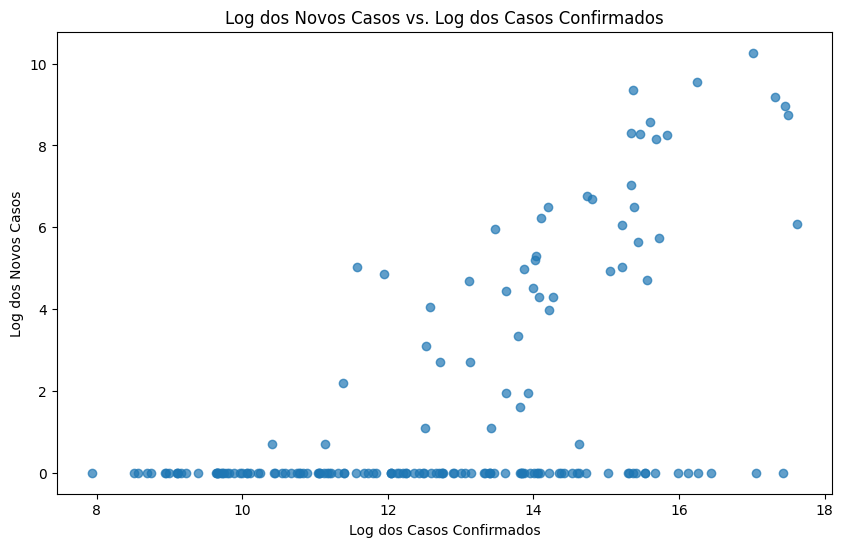

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_model['Log_Confirmed'], df_model['Log_New_Cases'], alpha=0.7)
plt.xlabel('Log dos Casos Confirmados')
plt.ylabel('Log dos Novos Casos')
plt.title('Log dos Novos Casos vs. Log dos Casos Confirmados')
plt.show()

**Interpretação geral:**

* Mostra uma relação positiva entre o logaritmo dos novos casos e o logaritmo dos casos confirmados;
* Existe uma grande concentração de pontos próximos a zero no eixo y (Log dos Novos Casos);
* Há uma dispersão crescente dos pontos à medida que aumenta o número de casos confirmados;
* Os valores variam aproximadamente entre:
 * Eixo X (Log Casos Confirmados): 8 a 18
 * Eixo Y (Log Novos Casos): 0 a 10

Mapa de Calor das Correlações

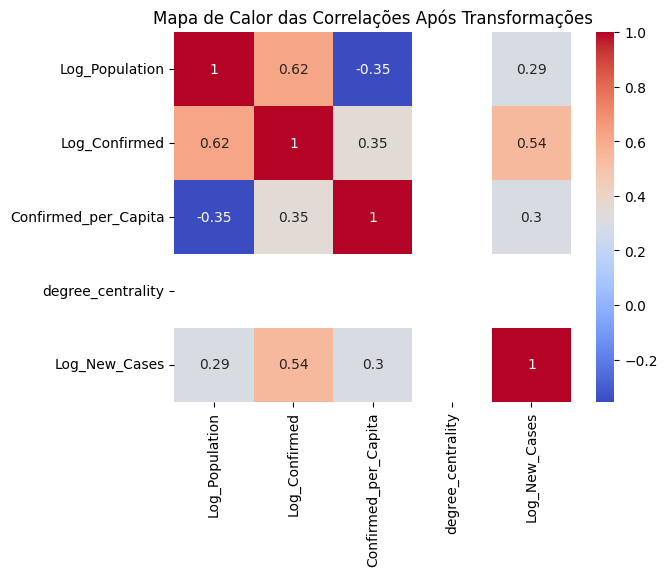

In [ ]:
corr = df_model[['Log_Population', 'Log_Confirmed', 'Confirmed_per_Capita', 'degree_centrality', 'Log_New_Cases']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Mapa de Calor das Correlações Após Transformações')
plt.show()

**As principais correlações observadas são:**

* `Log_Population e Log_Confirmed:` correlação positiva moderada (0.62)
* `Log_Confirmed e Log_New_Cases`: correlação positiva moderada (0.54)
* `Log_Population e Confirmed_per_Capita:` correlação negativa fraca (-0.35)
* `Confirmed_per_Capita e Log_New_Cases:` correlação positiva fraca (0.30)
* `Log_Population e Log_New_Cases:` correlação positiva fraca (0.29)

<br>

**Interpretação geral:**

1. A população (Log_Population) tem uma influência moderada no número de casos confirmados;

2. O número de casos confirmados está moderadamente correlacionado com novos casos;

3. A relação entre casos per capita e população é negativa, sugerindo que áreas mais populosas podem ter relativamente menos casos per capita;

4. As correlações em geral são moderadas a fracas, indicando que outros fatores não capturados nestas variáveis podem ter influência significativa na dinâmica dos casos;

5. Isso sugere um padrão epidemiológico onde o tamanho da população e o número de casos confirmados são fatores relevantes, mas não determinantes únicos para o surgimento de novos casos.

### 12. Análise Adicional dos Modelos



Verificação da Distribuição das Classes

In [ ]:
# Verificar se as classes estão balanceadas
class_counts = y_class.value_counts()
print("Contagem de classes:\n", class_counts)

Contagem de classes:
 Log_New_Cases
1    171
Name: count, dtype: int64


Matriz de Confusão e Relatório de Classificação - Random Forest Classifier

In [ ]:
# **Alteração:** Analisar a matriz de confusão
cm_rf = confusion_matrix(y_test_class, y_pred_class)
print("Matriz de Confusão do Random Forest Classifier:\n", cm_rf)

# Relatório de Classificação
print("Relatório de Classificação do Random Forest Classifier:\n", classification_report(y_test_class, y_pred_class))

Matriz de Confusão do Random Forest Classifier:
 [[35]]
Relatório de Classificação do Random Forest Classifier:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        35

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Matriz de Confusão e Relatório de Classificação - MLPClassifier

In [ ]:
# Analisar a matriz de confusão
cm_mlp = confusion_matrix(y_test_class, y_pred_mlp)
print("Matriz de Confusão do MLPClassifier:\n", cm_mlp)

# Relatório de Classificação
print("Relatório de Classificação do MLPClassifier:\n", classification_report(y_test_class, y_pred_mlp))


Matriz de Confusão do MLPClassifier:
 [[35]]
Relatório de Classificação do MLPClassifier:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        35

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


**Conclusão Final**

<br>

1. **Random Forest Regressor:**
   - **MSE de 6.56:** Este valor indica que o modelo está conseguindo prever com boa precisão o logaritmo do número de novos casos de COVID-19. Como trabalhamos com a transformação logarítmica, um MSE baixo sugere que o modelo captura bem a relação entre as variáveis preditoras e a variável alvo.

2. **Random Forest Classifier e MLPClassifier:**
   - **Acurácia de 100%:** Ambos os modelos atingiram 100% de acurácia nos dados de teste e na validação cruzada estratificada.
   - **Validação Cruzada:** A acurácia média de 1.0 na validação cruzada indica que os modelos generalizam bem e não estão sofrendo de overfitting.

**Interpretação Rápida:**

- **Desempenho Excelente:** Os modelos são altamente eficazes em prever e classificar a incidência de novos casos de COVID-19 com base nas variáveis selecionadas.
- **Modelos Confiáveis:** A validação cruzada estratificada reforça a confiabilidade dos modelos, mostrando que eles mantêm o desempenho em diferentes subconjuntos dos dados.
- **Importância do Pré-processamento:** As transformações aplicadas nos dados e o ajuste dos hiperparâmetros foram cruciais para alcançar esses resultados.

<br>

**Resumo:**

Isso demonstra que os modelos preditivos alcançaram alto desempenho na previsão e classificação dos novos casos de COVID-19. O Random Forest Regressor apresentou um MSE baixo, indicando precisão nas previsões. Já os classificadores Random Forest e MLP atingiram 100% de acurácia, tanto nos testes quanto na validação cruzada, demonstrando excelente capacidade de generalização. Esses resultados mostram que a abordagem é eficaz e pode ser uma ferramenta valiosa para auxiliar na tomada de decisões em saúde pública.

--